<a href="https://colab.research.google.com/github/WelfLowe/ML4developers/blob/main/6_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial Neural Networks (ANN)

ANN can be used for classification and for regression tasks. Below we demonstrate both.

## ANN for classification

We classify data from the IRIS data set with an ANN. It has the following architecture:

<img src="https://github.com/WelfLowe/ML4developers/blob/main/images/ANN_classification.png?raw=true" width=400>.

This is first part merely a copy of the tutorial on "Gradient descent on a Softmax cross-entropy cost function" found [here](https://madalinabuzau.github.io/2016/11/29/gradient-descent-on-a-softmax-cross-entropy-cost-function.html).

I adapted it to our running example of Iris classification and added history plots and some documentation.

Import useful libraries.

In [1]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

import pandas as pd
import sys

import tensorflow as tf
from tensorflow import keras

from keras.layers import Input, Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

Import Iris data.

In [2]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

Create a class for a Softmax linear classifier. Methods:
* $\verb|get_loss_grads|$ returns the gradients of the loss wrt. the weights and biases. It is used internally in the gradient descent methods.
* $\verb|train|$ optimizes the loss using gradient descent for a fixed number of iterations, i.e., it trains the model by iteratively adjusting the initial weights and biases in the direction of the negative gradient vector with smaller and smaller steps as the gradient vector approaches zero.  
* $\verb|train_early_stopping|$ same as $\verb|train|$, but it only stops if the accuracy on the validation set doesn't improve for a number of iterations.
* $\verb|predict|$ uses the model, i.e., the current weights and biases, for predicting classes.
* $\verb|eval|$ uses the model, i.e., the current weights and biases, for evaluating the accuraxy of the prdiction.

In [3]:
class Softmax(object):

  def __init__(self):
    self.W = None
    self.b = None
    self.history = []

  def get_loss_grads(self, X, y, reg, n_samples):
    # Linear mapping scores
    scores = np.dot(X, self.W)+self.b

    # Normalize the scores beforehand with max as zero to avoid
    # computational problems with the exponential
    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))

    # Softmax activation
    probs = exp_scores/np.sum(exp_scores, axis=1, keepdims=True)
    # Logloss of the correct class for each of our samples
    correct_logprobs = -np.log(probs[np.arange(n_samples), y])

    # Compute the average loss
    loss = np.sum(correct_logprobs)/n_samples

    # Add regularization using the L2 norm
    reg_loss = 0.5*reg*np.sum(self.W*self.W)
    loss += reg_loss

    # Gradient of the loss with respect to scores
    dscores = probs.copy()

    # Substract 1 from the scores of the correct class
    dscores[np.arange(n_samples),y] -= 1
    dscores /= n_samples

    # Gradient of the loss with respect to weights
    dW = X.T.dot(dscores)

    # Add gradient regularization
    dW += reg*self.W

    # Gradient of the loss with respect to biases
    db = np.sum(dscores, axis=0, keepdims=True)

    return loss, dW, db


  def train(self, X, y, learning_rate=1e-4, reg=0.5, num_iters=500):
    # Get useful parameters
    n_features = X.shape[1]
    n_samples = X.shape[0]
    n_classes = len(np.unique(y))

    # Initialize weights from a normal distribution and the biases with zeros
    if (self.W is None) & (self.b is None):
      np.random.seed(2016) # for reproducible results
      self.W = np.random.normal(loc=0.0, scale=1e-4, size=(n_features, n_classes))
      self.b = np.zeros((1, n_classes))

    for iter in range(num_iters):
      # Get loss and gradients
      loss, dW, db = self.get_loss_grads(X, y, reg, n_samples)

      # update weights and biases
      self.W -= learning_rate*dW
      self.b -= learning_rate*db

      # Compute validation accuracy
      accuracy = self.eval(X,y)
      self.history.append(accuracy)


  def train_early_stopping(self, X_train, y_train, X_val, y_val, learning_rate=1e-4, reg=0.5, early_stopping_rounds=200):
    # Get useful parameters_train
    n_features = X_train.shape[1]
    n_samples = X_train.shape[0]
    n_classes = len(np.unique(y))

    # Initialize weights from a normal distribution and the biases with zeros
    if (self.W is None) & (self.b is None):
      np.random.seed(2016) # for reproducible results
      self.W = np.random.normal(loc=0.0, scale=1e-4, size=(n_features, n_classes))
      self.b = np.zeros((1, n_classes))

    # Stores best accuracy found
    best_val_accuracy = -1

    # Stores the weights and biases of the best iteration
    best_weights, best_bias = None, None

    # Counts the number of no improvements in the accuracy
    no_improvement = 0

    # Boolean variable which helps us get out of the while loop
    keep_training = True

    while keep_training:

      # Get loss and gradients
      loss, dW, db = self.get_loss_grads(X_train, y_train, reg, n_samples)

      # update weights and biases
      self.W -= learning_rate*dW
      self.b -= learning_rate*db

      # Compute validation accuracy
      val_accuracy = self.eval(X_val,y_val)
      train_accuracy = self.eval(X_train,y_train)

      self.history.append([val_accuracy,train_accuracy])

      if val_accuracy>best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_weights, best_bias = self.W, self.b
        # reset count
        no_improvement = 0
      else:
        no_improvement += 1

      if no_improvement == early_stopping_rounds:
        self.W, self.b = best_weights, best_bias
        keep_training = False


  def predict(self, X):
    y_pred = np.dot(X, self.W)+self.b
    y_pred=np.argmax(y_pred, axis=1)

    return y_pred

  def eval(self, X, y):
    return np.mean(self.predict(X)==y)

Function for plotting the training history.

In [4]:
def plot_history(history, labels):
  x = range(len(history))
  hist_arr = np.asarray(history)
  if hist_arr.ndim==1:
    plt.plot(x, hist_arr, label=labels );
  else:
    i = 0
    for hist_row in hist_arr.transpose():
      plt.plot(x, hist_row, label = labels[i]);
      i += 1

  plt.title("Improvement of model performance over epochs")
  plt.xlabel("epochs")
  plt.ylabel("performance");
  plt.legend();

Train and assess the model on the whole dataset using a fixed number of training iterations.

Accuracy 0.8866666666666667


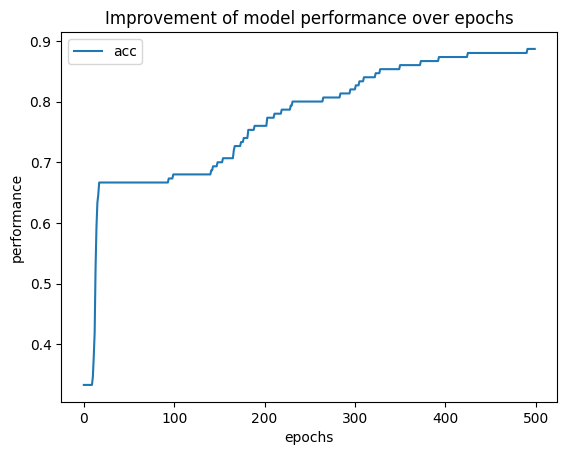

In [5]:
softmax = Softmax()
softmax.train( X, y, learning_rate=1e-2, reg=0.1, num_iters=500)
print('Accuracy', softmax.eval(X, y))
plot_history(softmax.history, 'acc')

Train and assess the model on the dataset split into training and validation subsets using early stopping.

Training accuracy 0.95
Validation accuracy 1.0


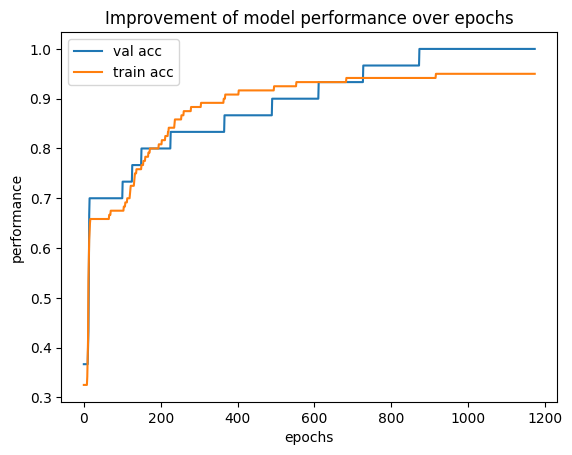

In [6]:
# Split dataset into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) #random_state=2

# Train with early stopping
softmax = Softmax()
softmax.train_early_stopping( X_train, y_train, X_val, y_val, learning_rate=1e-2, reg=0.1, early_stopping_rounds=300)
print('Training accuracy', softmax.eval(X_train, y_train))
print('Validation accuracy', softmax.eval(X_val, y_val))
plot_history(softmax.history, ['val acc', 'train acc'])

Build the same model using Tensorflow/Keras. Not that the result needs to be one-hot encoded (a vector or result classes with the ground truth class encoded as 1 and the others as 0.

In [7]:
n_classes = len(np.unique(y))
n_features = X.shape[1]
y_hot = to_categorical(y, n_classes)

In [8]:
def get_Softmax2_model():
  model = Sequential()
  model.add(Dense(n_classes, input_dim=n_features, activation='softmax'))
  model.compile(optimizer='adam',
			loss='categorical_crossentropy',
			metrics=['accuracy'])
  model.summary()
  return model

In [9]:
softmax = get_Softmax2_model()
r = softmax.fit(X, y_hot, epochs=500, verbose=0)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 3)                   │              15 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15 (60.00 B)

 Trainable params: 15 (60.00 B)

 Non-trainable params: 0 (0.00 B)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9398 - loss: 0.2649  
Loss, Acc [0.36872369050979614, 0.9066666960716248]


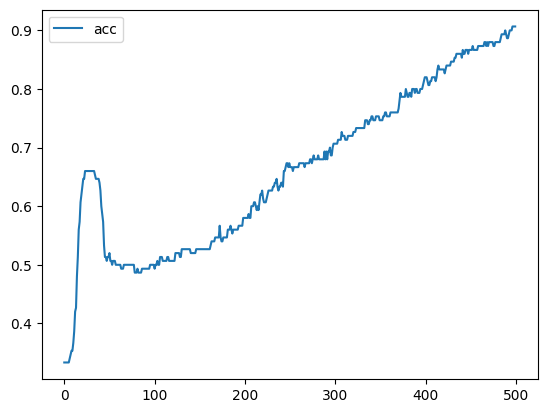

In [10]:
plt.plot(r.history['accuracy'], label='acc')
plt.legend()
result = softmax.evaluate(X, y_hot)
print('Loss, Acc', result)

We create another instance, otherwise we would just continue training the model.

In [11]:
y_train_hot = to_categorical(y_train, n_classes)
y_val_hot = to_categorical(y_val, n_classes)
cb = EarlyStopping(monitor='val_accuracy', mode='max', patience=300)
softmax = get_Softmax2_model()
r = softmax.fit(X_train, y_train_hot, validation_data=(X_val, y_val_hot), epochs=500, verbose=0, callbacks=[cb])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 3)                   │              15 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15 (60.00 B)

 Trainable params: 15 (60.00 B)

 Non-trainable params: 0 (0.00 B)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9283 - loss: 0.3537 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9000 - loss: 0.3582
Train Loss, Acc [0.3753325641155243, 0.925000011920929]
Val Loss, Acc [0.3582114577293396, 0.8999999761581421]


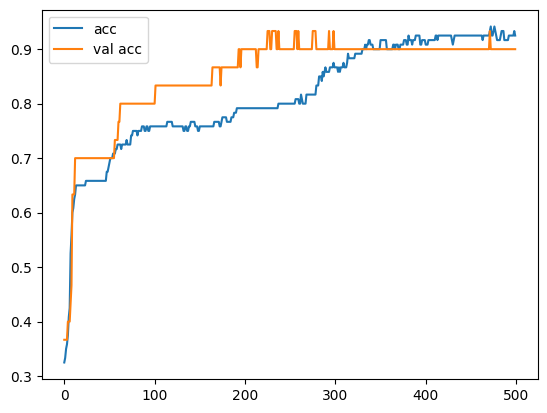

In [12]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
result_train = softmax.evaluate(X_train, y_train_hot)
result_val = softmax.evaluate(X_val, y_val_hot)
print('Train Loss, Acc', result_train)
print('Val Loss, Acc', result_val)

## ANN for regression

This second part uses a similar ANN approach for regression. Softmax is not applicable here as we don't want to restrict the output to values between 0 and 1. Also, we use the mean squared error (MSE) as the loss function instead of cross-entropy. This makes it essentially equivalent to linear regression. In is only interesting as the first step towards deep learning where we use several ANN layers and non-linear activation function to regress general functions.

We predict data from the California housing data set with an ANN. It has the following simple architecture:

<img src="https://github.com/WelfLowe/ML4developers/blob/main/images/ANN_regression.png?raw=true" width=400>.

We import the California housing dataset.

In [13]:
housing_data = fetch_california_housing()
df = pd.DataFrame(housing_data.data, columns=housing_data.feature_names)
X = df.to_numpy()
y = housing_data.target

print(df.columns)
print(X.shape,y.shape)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')
(20640, 8) (20640,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
X=X_train
y=y_train
print(X.shape,y.shape)

(4128, 8) (4128,)


Here the essential changes.

We implement the Glorot uniform initializer for setting the initial weights. It draws samples from a uniform random distribution in $-\textit{limit},\textit{limit}$  where $\textit{limit} = \sqrt{6/(\textit{idg}+\textit{odg})}$, and where $\textit{idg}$ and $\textit{odg}$ are the number of input (equals the number of features) and output nodes (equals 1), resp. The initial bias $b$ is initiall set to $0$.

Prediction works as before whereas evaluation uses MSE.

The gradients of the weights and the bias, resp., can be derived using the chain rule of the definitions of MSE and the linear prediction functions. They are calculated as below.

In [15]:
n_features, n_samples = X.shape[1], X.shape[0]
limit = np.sqrt(6/(n_features+1))
np.random.seed(42) # for reproducible results
W = np.random.uniform(low=-1*limit, high=limit, size=n_features)
b = 0
y_hat = np.dot(X, W)+b #predict
mse = ((y - y_hat)**2).mean() #eval = mse

dW = -2*X.T.dot(y - y_hat) /n_samples
db = -2*np.sum(y - y_hat) /n_samples

mse

1261498.1691393997

Given these changes, the regressor class is very similar to the softmax class. Note that in early stopping, MSE is expected to decrease for regression while accuracy is expected to increas. For deciding the stop criterion, we also add an epsilon of 0.1 to consider only significant improvements.

In [16]:
class Regressor(object):

  def __init__(self):
    self.W = None
    self.b = 0
    self.history = []

  def get_loss_grads(self, X, y, reg, n_samples):
    # Linear mapping scores
    y_hat = np.dot(X, self.W)+self.b

    # Compute the average loss
    mse = ((y - y_hat)**2).mean()

    # Add regularization using the L2 norm
    reg_loss = 0.5*reg*np.sum(self.W*self.W)
    mse += reg_loss

    # Gradient of the loss with respect to weights
    dW = -2 * X.T.dot(y - y_hat) /n_samples

    # Add gradient regularization
    dW += reg*self.W

    # Gradient of the loss with respect to biases
    db = -2 * np.sum(y - y_hat) /n_samples

    return mse, dW, db

  def init_weights(self, n_features):
    # Initialize weights from a normal distribution and the biases with zeros
    if (self.W is None):
      np.random.seed(42) # for reproducible results
      limit = np.sqrt(6/(n_features+1))
      self.W = np.random.uniform(low=-1*limit, high=limit, size=n_features)

  def train(self, X, y, learning_rate=1e-4, reg=0, num_iters=50):
    # Get useful parameters
    n_features = X.shape[1]
    n_samples = X.shape[0]
    self.init_weights(n_features)

    for iter in range(num_iters):
      # Get loss and gradients
      mse, dW, db = self.get_loss_grads(X, y, reg, n_samples)

      # update weights and biases
      self.W -= learning_rate*dW
      self.b -= learning_rate*db

      # Compute validation accuracy
      mse = self.eval(X, y)
      self.history.append(mse)


  def train_early_stopping(self, X_train, y_train, X_val, y_val, learning_rate=1e-4, reg=0.5, early_stopping_rounds=10):
    # Get useful parameters_train
    n_features = X_train.shape[1]
    n_samples = X_train.shape[0]
    self.init_weights(n_features)

    # Stores best accuracy found
    best_val_mse = sys.float_info.max

    # Stores the weights and biases of the best iteration
    best_weights, best_bias = None, None

    # Counts the number of no improvements in the accuracy
    no_improvement = 0

    # Boolean variable which helps us get out of the while loop
    keep_training = True

    while keep_training:

      # Get loss and gradients
      mse, dW, db = self.get_loss_grads(X_train, y_train, reg, n_samples)

      # update weights and biases
      self.W -= learning_rate*dW
      self.b -= learning_rate*db

      # Compute validation accuracy
      val_mse = self.eval(X_val,y_val)
      train_mse = self.eval(X_train,y_train)

      self.history.append([val_mse,train_mse])

      if val_mse + 0.1 < best_val_mse: #delta > 0.1
        best_val_mse = val_mse
        best_weights, best_bias = self.W, self.b
        # reset count
        no_improvement = 0
      else:
        no_improvement += 1

      if no_improvement == early_stopping_rounds:
        self.W, self.b = best_weights, best_bias
        keep_training = False


  def predict(self, X):
    y_hat = np.dot(X, self.W)+self.b
    return y_hat

  def eval(self, X, y):
    y_hat = self.predict(X)
    return ((y - y_hat)**2).mean()

Training with a fixed number of 1000 iterations. Mind the changed learning rate.

MSE 247.11029578433323


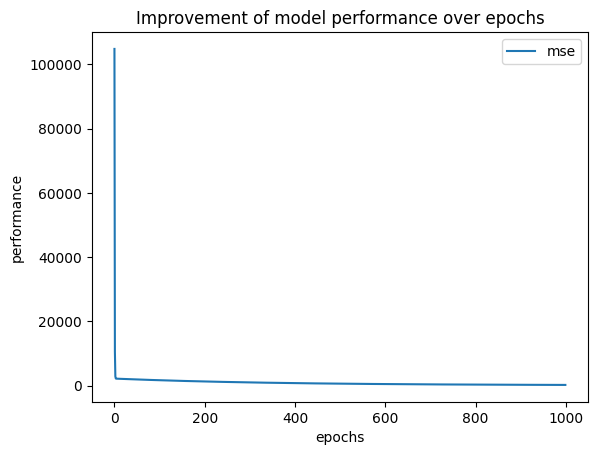

In [17]:
np.random.seed(42) # for reproducible results

regressor = Regressor()
regressor.train( X, y, learning_rate=1e-7, reg=0.5, num_iters=1000)
print('MSE', regressor.eval(X, y))
plot_history(regressor.history, 'mse')

Training and evaluating with early stopping.

Training MSE 120.22243834581583
Validation MSE 93.62578131721901


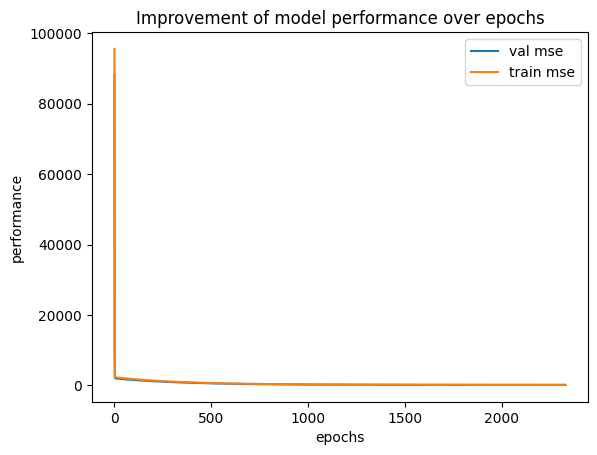

In [18]:
np.random.seed(42) # for reproducible results

# Split dataset into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train with early stopping
regressor = Regressor()
regressor.train_early_stopping( X_train, y_train, X_val, y_val, learning_rate=1e-7, reg=0.5, early_stopping_rounds=10)
print('Training MSE', regressor.eval(X_train, y_train))
print('Validation MSE', regressor.eval(X_val, y_val))
plot_history(regressor.history, ['val mse', 'train mse'])

Building the same ANN with Tensorflow/Keras.

In [19]:
def get_Regression_model():
  model = Sequential()
  model.add(Dense(1, input_dim=n_features, activation='linear'))
  model.compile(optimizer='adam',
			loss='mse',
			metrics=['mse'])
  model.summary()
  return model

In [20]:
regressor = get_Regression_model()
r = regressor.fit(X, y, epochs=500, verbose=0)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9 (36.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 0 (0.00 B)

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6826 - mse: 0.6826
MSE 0.6717019081115723


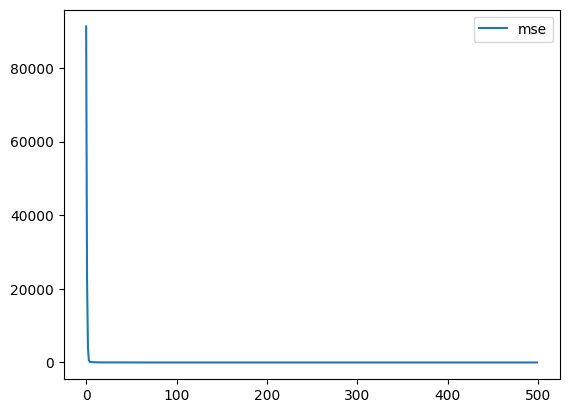

In [21]:
plt.plot(r.history['mse'], label='mse')
plt.legend()
result = regressor.evaluate(X, y)
print('MSE', result[0])

In [22]:
cb = EarlyStopping(monitor='val_mse', mode='min', min_delta=0.1, patience=10)
regressor = get_Regression_model()
r = regressor.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, verbose=0, callbacks=[cb])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9 (36.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 0 (0.00 B)

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2285 - mse: 1.2285
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1876 - mse: 1.1876 
Training MSE 1.2440814971923828
Validation MSE 1.2415237426757812


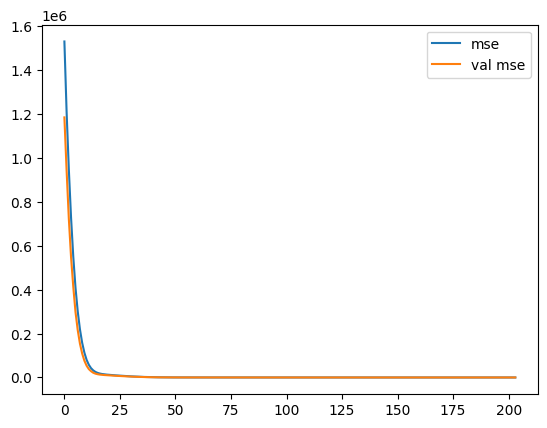

In [23]:
plt.plot(r.history['mse'], label='mse')
plt.plot(r.history['val_mse'], label='val mse')
plt.legend()

result_train = regressor.evaluate(X_train, y_train)
result_val = regressor.evaluate(X_val, y_val)
print('Training MSE', result_train[0])
print('Validation MSE', result_val[0])

## Advanced: Two Layer ANN and Back-Propagation

Now, we a another layer of "neurons" and a non-linear "activation" function for each neuron in the first layer. This allows the optimization to train a non-linear model. Details about the example are explained [here](https://www.youtube.com/watch?v=dxZ8a-oIu7U).

Again we predict data from the Boston data set with an ANN. It has the following two-layered architecture:

<img src="https://github.com/WelfLowe/ML4developers/blob/main/images/ANN_regression2.png?raw=true" width=400>.

We transpose both the predictors and the responses, i.e., data points are encoded in columns instead of row.

In [24]:
XT = X.T
yT = y.reshape(1, -1)
print(XT.shape, yT.shape)

(8, 4128) (1, 4128)


Next we define a non-linear activation function. We use the [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) instead of the softmax activation function as in the classification example above. Both map input values to $[0,1]$; please find a cpmarison [here](https://medium.com/arteos-ai/the-differences-between-sigmoid-and-softmax-activation-function-12adee8cf322).

In [25]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

For demonstration, we
- initialize the weight matrices and bias vectors of the two layers ($\verb|W1,b1,W2,b2|$),
- compute a prediction (vector) of *all* datapoints ($\verb|y2|$),
- compute the loss of the prediction ($\verb|mse|$) by two simple matrix mutiplications with the application of the sigmoid activation in between,
- compute the gradients of ($\verb|W1,b1,W2,b2|$), and
- check if the gradients of weights and biases have the same shape as the respective weight matrix and bias vector.

In [26]:
np.random.seed(42) # for reproducible results

n_features, n_samples = XT.shape[0], XT.shape[1]
print("features, samples",n_features, n_samples)
limit1 = np.sqrt(6/(n_features+3))
W1 = np.random.uniform(low=-limit1, high=limit1, size=(3, n_features))
b1 = np.zeros((3,1))
limit2 = np.sqrt(6/(3+1))
W2 = np.random.uniform(low=-limit2, high=limit2, size=(1, 3))
b2 = np.zeros((1,1))

#predict
y1 = np.matmul(W1, XT)+b1 # level 1 neurons
s=sigmoid(y1)
y2 = np.matmul(W2, s)+b2 # level 2 neurons

#eval
mse = ((yT - y2)**2).mean() #eval = mse

#gradients
dy2 = 2 *(y2-yT)
dW2 = np.matmul(dy2, s.T)
db2 = np.matmul(dy2, np.ones((n_samples,1)))
ds = np.matmul(W2.T, dy2)
dy1 = ds * s * sigmoid(1-s)
dW1 = np.matmul(dy1, X) #XT transposed back
db1 = np.matmul(dy1, np.ones((n_samples,1)))

#check shapes
print(W1.shape,dW1.shape)
print(b1.shape,db1.shape)
print(W2.shape,dW2.shape)
print(b2.shape,db2.shape)

features, samples 8 4128
(3, 8) (3, 8)
(3, 1) (3, 1)
(1, 3) (1, 3)
(1, 1) (1, 1)


<ipython-input-25-3db925c61081>:1: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda x: 1 / (1 + np.exp(-x))


Since everythings seems to be sound, we update the regressor class with new new computations.

In [27]:
class Regressor2(object):

  def __init__(self):
    self.W1 = None
    self.b1 = None
    self.W2 = None
    self.b2 = None
    self.n_features = 0
    self.n_samples = 0
    self.history = []

  def get_loss_grads(self, X, y, reg):
    #predict
    y1 = np.matmul(self.W1, X)+self.b1 # level 1 neurons
    s=sigmoid(y1)
    y2 = np.matmul(self.W2, s)+self.b2 # level 2 neurons

    #gradients
    dy2 = 2 *(y2-y)
    dW2 = np.matmul(dy2, s.T)
    dW2 += reg*self.W2
    db2 = np.matmul(dy2, np.ones((self.n_samples,1)))
    ds = np.matmul(self.W2.T, dy2)
    dy1 = ds * s * sigmoid(1-s)
    dW1 = np.matmul(dy1, X.T)
    dW1 += reg*self.W1
    db1 = np.matmul(dy1, np.ones((self.n_samples,1)))

    return dW2, db2, dW1, db1

  def init_weights(self,X):
    # Initialize weights from a normal distribution and the biases with zeros
    if (self.W2 is None):
      self.n_features, self.n_samples = X.shape[0], X.shape[1]
      limit1 = np.sqrt(6/(self.n_features+3))
      self.W1 = np.random.uniform(low=-limit1, high=limit1, size=(3, self.n_features))
      self.b1 = np.zeros((3,1))
      limit2 = np.sqrt(6/(3+1))
      self.W2 = np.random.uniform(low=-limit2, high=limit2, size=(1, 3))
      self.b2 = np.zeros((1,1))

  def train(self, X, y, learning_rate=1e-4, reg=0, num_iters=50):
    # Get useful parameters
    self.init_weights(X)

    for iter in range(num_iters):
      # Get loss and gradients
      dW2, db2, dW1, db1 = self.get_loss_grads(X, y, reg)

      # update weights and biases
      self.W2 -= learning_rate*dW2
      self.b2 -= learning_rate*db2
      self.W1 -= learning_rate*dW1
      self.b1 -= learning_rate*db1

      # Compute validation accuracy
      mse = self.eval(X, y)
      self.history.append(mse)


  def train_early_stopping(self, X_train, y_train, X_val, y_val, learning_rate=1e-4, reg=0.5, early_stopping_rounds=200):
    # Get useful parameters_train
    self.init_weights(X_train)

    # Stores best accuracy found
    best_val_mse = sys.float_info.max

    # Stores the weights and biases of the best iteration
    best_W2, best_b2, best_W1, best_b1 = None, None, None, None

    # Counts the number of no improvements in the accuracy
    no_improvement = 0

    # Boolean variable which helps us get out of the while loop
    keep_training = True

    while keep_training:

      # Get loss and gradients
      dW2, db2, dW1, db1 = self.get_loss_grads(X_train, y_train, reg)

      # update weights and biases
      self.W2 -= learning_rate*dW2
      self.b2 -= learning_rate*db2
      self.W1 -= learning_rate*dW1
      self.b1 -= learning_rate*db1

      # Compute validation accuracy
      val_mse = self.eval(X_val,y_val)
      train_mse = self.eval(X_train,y_train)

      self.history.append([val_mse, train_mse])

      if val_mse + 0.1 < best_val_mse: #epsilon = 0.1
        best_val_mse = val_mse
        best_W2 = self.W2
        best_b2 = self.b2
        best_W1 = self.W1
        best_b1 = self.b1
        # reset count
        no_improvement = 0
      else:
        no_improvement += 1

      if no_improvement == early_stopping_rounds:
        self.W2 = best_W2
        self.b2 = best_b2
        self.W1 = best_W1
        self.b1 = best_b1
        keep_training = False


  def predict(self, X):
    y1 = np.matmul(self.W1, X)+self.b1 # level 1 neurons
    s=sigmoid(y1)
    y2 = np.matmul(self.W2, s)+self.b2 # level 2 neurons
    return y2

  def eval(self, X, y):
    y2 = self.predict(X)
    mse = ((y - y2)**2).mean() #eval = mse
    return mse

We train again with a fixed number of 1000 iterations on the whole dataset.

<ipython-input-25-3db925c61081>:1: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda x: 1 / (1 + np.exp(-x))


MSE 1.3459873565903016


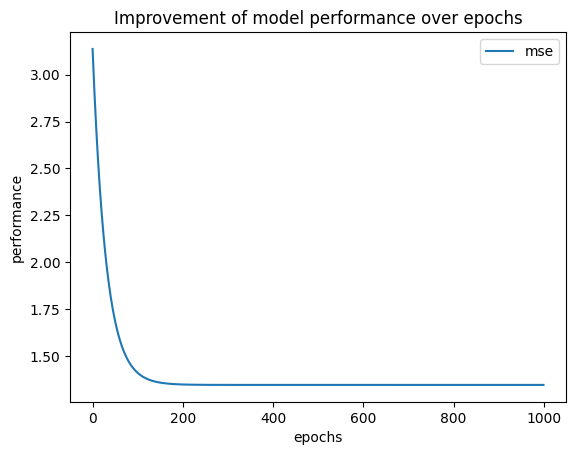

In [28]:
np.random.seed(42) # for reproducible results

regressor = Regressor2()
regressor.train(XT, yT, learning_rate=1e-6, reg=0.5, num_iters=1000)
print('MSE', regressor.eval(XT, yT))
plot_history(regressor.history, 'mse')

Training converges slower now, but arrive eventually at a lower error than the simple model we created before.

Now we train with early stopping on a validation set. Mind that we need to transpose the dataset befor splitting and the result back again before regression.

<ipython-input-25-3db925c61081>:1: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda x: 1 / (1 + np.exp(-x))


Training MSE 1.5989879423853333
Validation MSE 1.7297887156776937


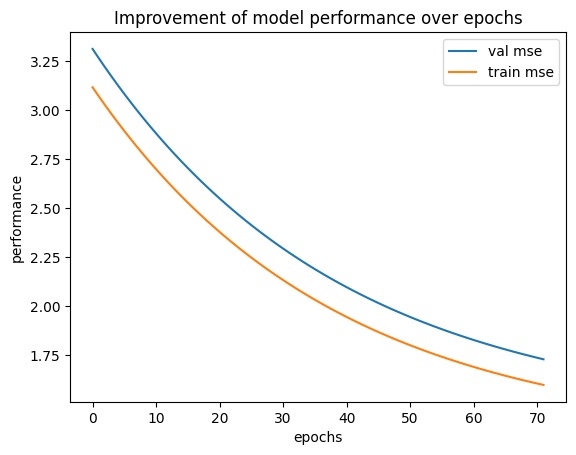

In [29]:
np.random.seed(42) # for reproducible results

# Split dataset into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_T = X_train.T
X_val_T = X_val.T
y_train_T = y_train.T
y_val_T = y_val.T

# Train with early stopping
regressor2 = Regressor2()
regressor2.train_early_stopping(X_train_T, y_train_T, X_val_T, y_val_T, learning_rate=1e-6, reg=0.1, early_stopping_rounds=10)
print('Training MSE', regressor2.eval(X_train_T, y_train_T))
print('Validation MSE', regressor2.eval(X_val_T, y_val_T))
plot_history(regressor2.history, ['val mse', 'train mse'])

This gives a more accurate prediction model than our overtrained model.

Building the same model with Tensorflow/Keras.

In [30]:
def get_Regression2_model():
  model = Sequential()
  model.add(Dense(3, input_dim=n_features, activation='sigmoid'))
  model.add(Dense(1, input_dim=3, activation='linear'))
  model.compile(optimizer='adam',
			loss='mse',
			metrics=['mse'])
  model.summary()
  return model

In [31]:
regressor = get_Regression2_model()
r = regressor.fit(X, y, epochs=1000, verbose=0)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 3)                   │              27 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31 (124.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6925 - mse: 0.6925
MSE 0.6938591003417969


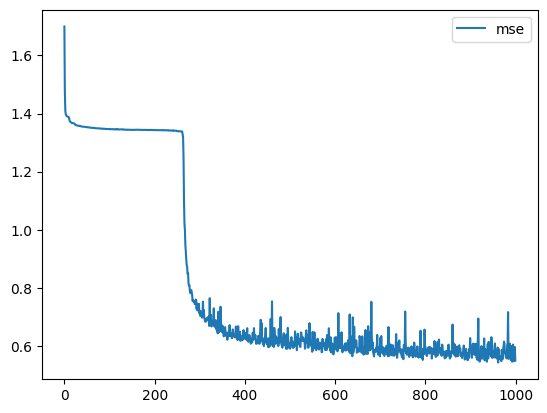

In [32]:
plt.plot(r.history['mse'], label='mse')
plt.legend()
result = regressor.evaluate(X, y)
print('MSE', result[0])

We again observe a slower convergence, but arrive at a lower MSE than our handmade regressor models.

Now with early stopping. Mind the higher patience to achieve plateauing.

In [33]:
cb = EarlyStopping(monitor='val_mse', mode='min', min_delta=0.1, patience=100)
regressor = get_Regression2_model()
r = regressor.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, verbose=0, callbacks=[cb])

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 3)                   │              27 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31 (124.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3289 - mse: 1.3289
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3719 - mse: 1.3719 
Training MSE 1.324257493019104
Validation MSE 1.424116849899292


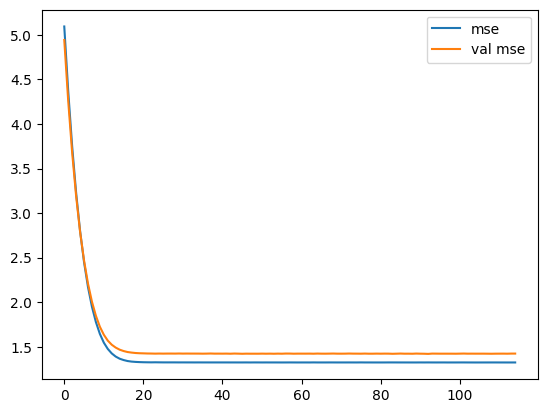

In [34]:
plt.plot(r.history['mse'], label='mse')
plt.plot(r.history['val_mse'], label='val mse')
plt.legend()

result_train = regressor.evaluate(X_train, y_train)
result_val = regressor.evaluate(X_val, y_val)
print('Training MSE', result_train[0])
print('Validation MSE', result_val[0])

Even better than our own model, but not as good as the simple one-layered model based on Tensorflow/Keras. However, before we generalize that a linear model is more appropriate here, we should check all models with cross-validation.